In [45]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read scenario data

Refer to **read_data.ipynb** for insight regarding how the data is generated and structured.

In [22]:
with open('Data/250_scenarios.json') as f:
    scenarios = json.load(f)

scenarios.keys()

dict_keys(['Sample Scenarios', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '

# One-price Scheme (RESULTS NEED VALIDATION as they are a bit strange)

*(Task 1.a)*

## Run model

In [46]:
OMEGA = len(scenarios.keys()) - 1 # number of scenarios
T = 24 # number of hours
PI = 1 / OMEGA # probability of each scenario - assumed to be equal
WIND_CAPACITY = 200 #MWh

direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price

#============= Objective function =============
# Set objective function - note that the day-ahead price is factored out of the sum
obj = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w]) for t in range(T) for w in range(OMEGA))
m.setObjective(obj, direction)

#============= Day-ahead power bid limits ============

#Upper limit is the nominal wind power
m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

#============= Power imbalance definition (realized - bid) ===============
m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

#============= Price coefficient definition ===============
# the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

#============= Display and run model =============
m.update()
#m.display()
m.optimize()

#============= Results =============
if m.status == gb.GRB.OPTIMAL:
    #initialization
    results = {}
    for scenario in range(OMEGA):
        df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State', 'Balancing Price Coefficient'])
        
        for t in range(T):
            df.loc[t] = [t, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                         scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x, 
                         delta[t,scenario].x, scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                         price_coeff[t,scenario].x * scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * delta[t,scenario].x, 
                         scenarios[str(scenario)]['System Balance State'][t], price_coeff[t,scenario].x]
        df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

        df['Hour'] = df['Hour'].astype(int)
        df['System State'] = df['System State'].astype(int)
        df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
        df.set_index('Hour', inplace=True)
        results[scenario] = df.copy(deep=True)

    print('-----------------------------------------------')
    print('Objective value (expected profit): %.2f EUR' % m.objVal)
    print('-----------------------------------------------')
    print('Day-ahead bids:')
    average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

    summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
    for t in range(T):
        summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]), np.mean([price_coeff[t,w].x for w in range(OMEGA)])]

    summary['Hour'] = summary['Hour'].astype(int)
    summary.set_index('Hour', inplace=True)

    results['Summary'] = summary.copy(deep=True)

    for t in range(T):
        print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

    print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
    print('-----------------------------------------------')
    print('Runtime: %f ms' % (m.Runtime * 1e3))
else:
    print("Optimization was not successful.")     

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12024 rows, 12024 columns and 18024 nonzeros
Model fingerprint: 0x6aed81f4
Model has 6000 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+01, 1e+02]
  QObjective range [5e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+02]
Presolve removed 12024 rows and 12024 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.01 work units)
Optimal objective 1.69945645e+05
-----------------------------------------------
Objective value (expected profit): 169945.65 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 0.00 MW | Average Profit: 6088.45 EUR
Hour 1 | Bid: 0.00

In [47]:
results['Summary']

,DA Bid [MW],Average Profit [EUR],Average Wind [MW],Median Wind [MW],Average System State,Average Price Coefficient
Hour,,,,,,
0,0.0,6088.447046,75.971079,58.187117,0.624,1.0872
1,0.0,6201.167928,75.421622,58.491371,0.816,1.1448
2,0.0,5634.325847,74.729242,56.260609,0.612,1.0836
3,0.0,5337.310364,74.219424,60.798811,0.624,1.0872
4,0.0,4900.243826,73.432345,59.646459,0.380,1.0140
5,0.0,5310.138626,72.983684,64.686541,0.440,1.0320
6,200.0,6318.351520,72.050807,73.145411,0.184,0.9552
7,0.0,6812.609374,71.763649,73.439255,0.428,1.0284
8,200.0,7829.890960,72.011247,79.261132,0.244,0.9732


In [48]:
results[3] #check results for a specific scenario

,DA Price [EUR/MWh],Wind Power [MW],DA Bid [MW],Imbalance [MW],DA Profit [EUR],Balancing Profit [EUR],System State,Balancing Price Coefficient,Total Profit [EUR]
Hour,,,,,,,,,
0,86.129997,103.608684,0.0,103.608684,0.0000,10708.578722,Deficit,1.2,10708.578722
1,82.930000,114.242993,0.0,114.242993,0.0000,11369.005710,Deficit,1.2,11369.005710
2,80.099998,116.373771,0.0,116.373771,0.0000,11185.846611,Deficit,1.2,11185.846611
3,76.550003,121.443913,0.0,121.443913,0.0000,11155.838318,Deficit,1.2,11155.838318
4,75.160004,127.794000,0.0,127.794000,0.0000,11525.997028,Deficit,1.2,11525.997028
5,80.410004,136.871895,0.0,136.871895,0.0000,9905.282667,Surplus,0.9,9905.282667
6,95.970001,140.803080,200.0,-59.196920,19194.0002,-6817.354195,Deficit,1.2,12376.646005
7,106.949997,140.568575,0.0,140.568575,0.0000,13530.427806,Surplus,0.9,13530.427806
8,121.500000,145.633920,200.0,-54.366080,24300.0000,-5944.930843,Surplus,0.9,18355.069157


## Visualize results

Plot vs. average "system state" and median realized wind power

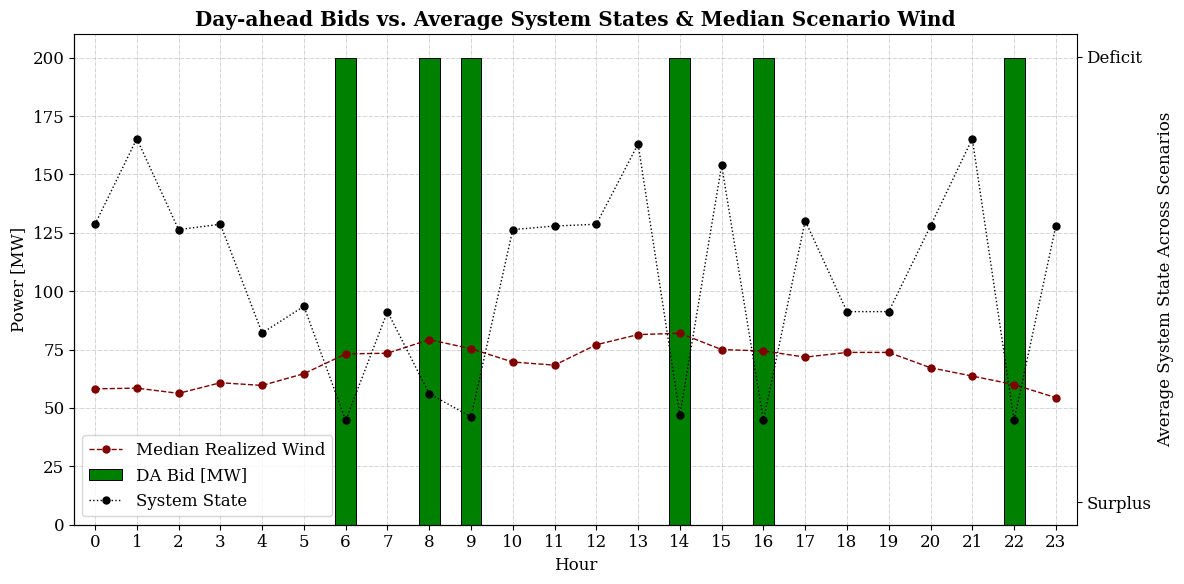

In [50]:
DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

ax2.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0, 1.05 * WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left')

ax1.set_title('Day-ahead Bids vs. Average System States & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([-0.05,1.05])
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Surplus', 'Deficit'])

ax2.set_ylabel('Average System State Across Scenarios')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()
plt.savefig('Figures/One-price_BID_vs_SYSTEMSTATE_and_WIND.png', dpi=300, bbox_inches='tight')
plt.show()

<span style="color: red;">**Notes:**</span>
* Most places have one-price schemes now since it rewards those who help the system and penalizes those who don't, whereas the **two-price** scheme only punishes bad performance.
* The results seen in this optimization make sense when we can reliably predict if the system is in excess or deficit, but in reality you would want to bid closer to your expected production to avoid being penalized in the balancing market. **Maybe the results will be different if we use more scenarios?**
* Energinet generally does not have rules in place for how much imbalance you are allowed to be in - in other places, this can be punished to a larger degree.
* Behaviour will be dependent on scenario data, but wind tends to be pretty random.
* If we had a larger sample of "System State Scenarios" it might tend to be more balanced.

System State:
* 0 = Excess
* 1 = Deficit

When there is often a deficit (higher balancing price), it is seen to save the capacity until the balancing market.

# Two-price Scheme

*(Task 1.b)*

## Run model

In [51]:
OMEGA = len(scenarios.keys()) - 1 # number of scenarios
T = 24 # number of hours
PI = 1 / OMEGA # probability of each scenario - assumed to be equal
WIND_CAPACITY = 200 #MWh

direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid

delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up") # surplus
delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down") # deficit

imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I") # imbalance revenue - can be negative

# binary variables used to control the two-price logic
y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")
z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")

#============= Objective function =============
# Set objective function
obj = gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
m.setObjective(obj, direction)

#============= Day-ahead power bid limits ============

#Upper limit is the nominal wind power
m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

#============= Power imbalance definitions ===============
m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
m.addConstrs(delta[t,w] == delta_up[t,w] - delta_down[t,w] for t in range(T) for w in range(OMEGA))


M = 1e6 # big-M constant
#ensure that only one of the delta directions can be non-zero
m.addConstrs(delta_up[t,w] <= M * (1 - y[t,w]) for t in range(T) for w in range(OMEGA))
m.addConstrs(delta_down[t,w] <= M * y[t,w] for t in range(T) for w in range(OMEGA))

#============= Linearized conditional statements ===============
#Binary variable constraints
m.addConstrs(z[0,t,w] <= y[t,w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
m.addConstrs(z[1,t,w] <= y[t,w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
m.addConstrs(z[2,t,w] <= (1 - y[t,w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
m.addConstrs(z[3,t,w] <= (1 - y[t,w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

# if system is in a surplus and the imbalance is positive (NOT helping the system)
m.addConstrs(imbalance_revenue[t,w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[0,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a deficit and the imbalance is positive (IS helping the system)
m.addConstrs(imbalance_revenue[t,w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[1,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a surplus and the imbalance is negative (IS helping the system)
m.addConstrs(imbalance_revenue[t,w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[2,t,w] for t in range(T) for w in range(OMEGA))

# if system is in a deficit and the imbalance is negative (NOT helping the system)
m.addConstrs(imbalance_revenue[t,w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[3,t,w] for t in range(T) for w in range(OMEGA))

#============= Display and run model =============
m.update()
#m.display()
m.optimize()

#============= Results =============
if m.status == gb.GRB.OPTIMAL:
    #initialization
    results = {}
    for scenario in range(OMEGA):
        df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]' ,'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])
        
        for t in range(T):
            df.loc[t] = [t, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                         scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                         delta[t,scenario].x, 
                         delta_up[t,scenario].x, 
                         delta_down[t,scenario].x, 
                         scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                         imbalance_revenue[t,scenario].x, 
                         scenarios[str(scenario)]['System Balance State'][t]]
        df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

        df['Hour'] = df['Hour'].astype(int)
        df['System State'] = df['System State'].astype(int)
        df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
        df.set_index('Hour', inplace=True)
        results[scenario] = df.copy(deep=True)

    print('-----------------------------------------------')
    print('Objective value (expected profit): %.2f EUR' % m.objVal)
    print('-----------------------------------------------')
    print('Day-ahead bids:')
    average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

    summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State'])
    for t in range(T):
        summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)])]

    summary['Hour'] = summary['Hour'].astype(int)
    summary.set_index('Hour', inplace=True)

    results['Summary'] = summary.copy(deep=True)

    for t in range(T):
        print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

    print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
    print('-----------------------------------------------')
    print('Runtime: %f ms' % (m.Runtime * 1e3))
else:
    print("Optimization was not successful.")     

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 72024 rows, 54024 columns and 174024 nonzeros
Model fingerprint: 0x6c21b783
Variable types: 24024 continuous, 30000 integer (30000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+06]
Found heuristic solution: objective 16202.938137
Presolve removed 45744 rows and 32976 columns
Presolve time: 1.10s
Presolved: 26280 rows, 21048 columns, 65165 nonzeros
Variable types: 15792 continuous, 5256 integer (5256 binary)

Root relaxation: objective 1.995517e+05, 17653 iterations, 0.23 seconds (0.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

In [52]:
results['Summary']

,DA Bid [MW],Average Profit [EUR],Average Wind [MW],Median Wind [MW],Average System State
Hour,,,,,
0,34.429065,5469.516002,75.971079,58.187117,0.624
1,17.363054,5337.919582,75.421622,58.491371,0.816
2,25.516105,5055.426330,74.729242,56.260609,0.612
3,27.733224,4786.765140,74.219424,60.798811,0.624
4,52.012413,4656.870788,73.432345,59.646459,0.380
5,48.027292,4963.345210,72.983684,64.686541,0.440
6,110.630951,5659.316099,72.050807,73.145411,0.184
7,44.485352,6365.117219,71.763649,73.439255,0.428
8,82.469291,7199.759717,72.011247,79.261132,0.244


Check that the z-variables are (likely) working as intended...

In [53]:
for scenario in range(OMEGA):
    for t in range(T):
        if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
            print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)

Check that results make sense for different scenarios

In [54]:
results[3] #check results for a specific scenario

,DA Price [EUR/MWh],Wind Power [MW],DA Bid [MW],Delta [MW],Delta UP [MW],Delta DOWN [MW],DA Profit [EUR],Balancing Profit [EUR],System State,Total Profit [EUR]
Hour,,,,,,,,,,
0,86.129997,103.608684,34.429065,69.179618,69.179618,0.0,2965.375304,5958.440297,Deficit,8923.815601
1,82.930000,114.242993,17.363054,96.879939,96.879939,0.0,1439.918052,8034.253373,Deficit,9474.171425
2,80.099998,116.373771,25.516105,90.857666,90.857666,0.0,2043.839984,7277.698859,Deficit,9321.538843
3,76.550003,121.443913,27.733224,93.710689,93.710689,0.0,2122.978386,7173.553546,Deficit,9296.531932
4,75.160004,127.794000,52.012413,75.781586,75.781586,0.0,3909.253197,5695.744326,Deficit,9604.997523
5,80.410004,136.871895,48.027292,88.844603,88.844603,0.0,3861.874739,6429.595402,Surplus,10291.470141
6,95.970001,140.803080,110.630951,30.172129,30.172129,0.0,10617.252483,2895.619222,Deficit,13512.871705
7,106.949997,140.568575,44.485352,96.083223,96.083223,0.0,4757.708237,9248.490393,Surplus,14006.198630
8,121.500000,145.633920,82.469291,63.164629,63.164629,0.0,10020.018880,6907.052164,Surplus,16927.071045


## Visualize results

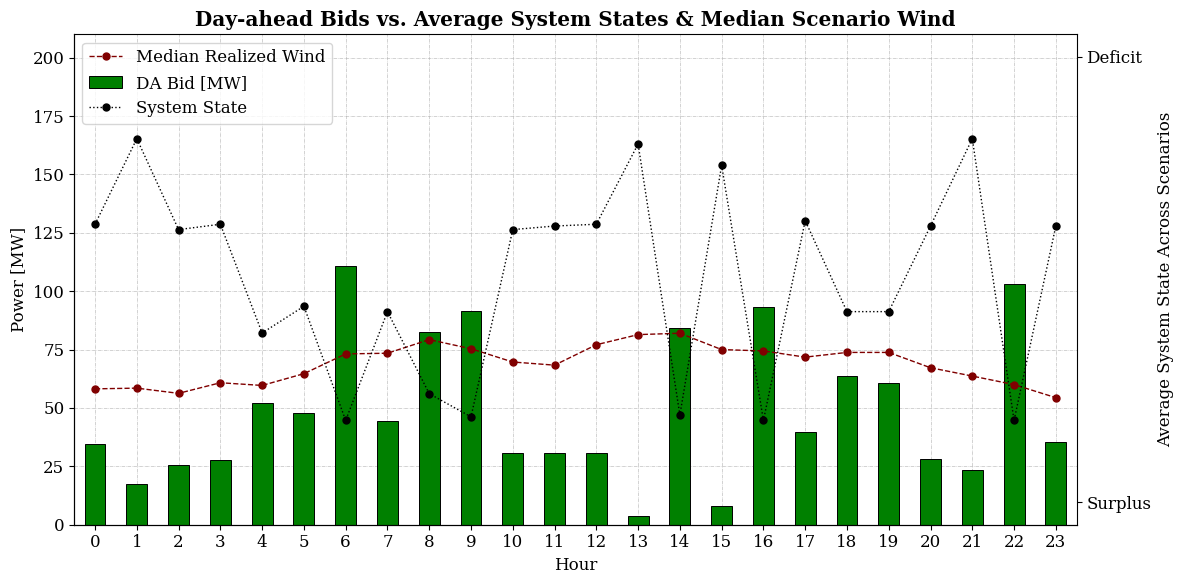

In [55]:
DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

ax2.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0,1.05 *WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.set_title('Day-ahead Bids vs. Average System States & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([-0.05,1.05])
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Surplus', 'Deficit'])

ax2.set_ylabel('Average System State Across Scenarios')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()

plt.savefig('Figures/Two-price_BID_vs_SYSTEMSTATE_and_WIND.png', dpi=300, bbox_inches='tight')
plt.show()

Similar plot with day-ahead prices instead of realized wind

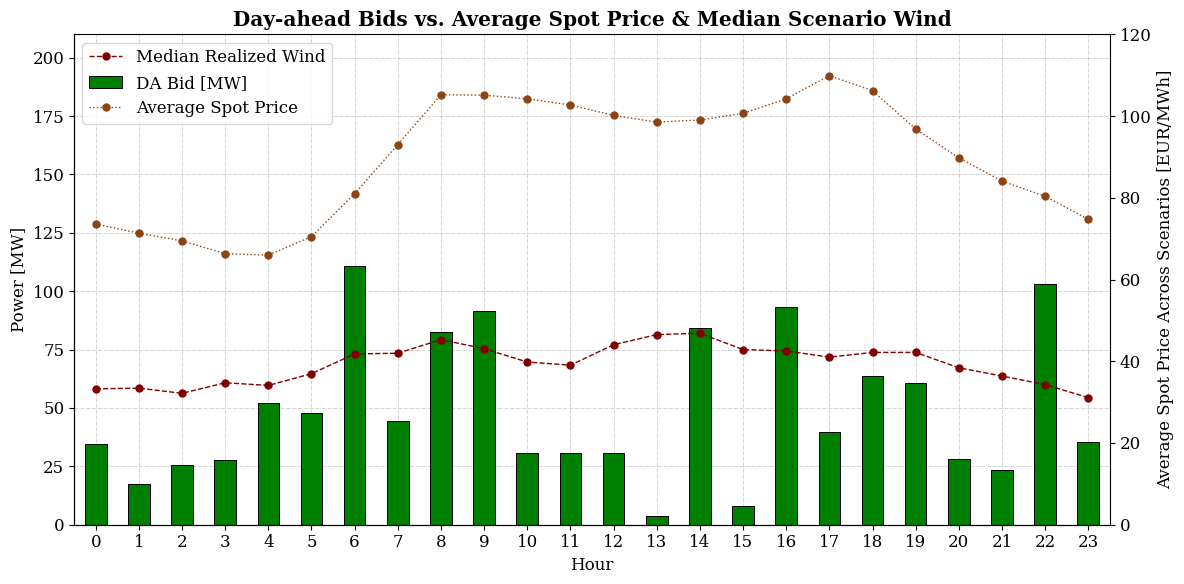

In [56]:
DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

#Average spot price across scenarios
average_spot_price = np.mean([scenarios[str(w)]['Spot Price [EUR/MWh]'] for w in range(OMEGA)], axis=0)

ax2.plot(average_spot_price, color='saddlebrown', linewidth=1, label='Average Spot Price', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0,1.05 *WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.set_title('Day-ahead Bids vs. Average Spot Price & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([0,120])

ax2.set_ylabel('Average Spot Price Across Scenarios [EUR/MWh]')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()

plt.savefig('Figures/Two-price_BID_vs_SPOT_and_WIND.png', dpi=300, bbox_inches='tight')

plt.show()